In [145]:
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [192]:
# Imports
from os.path import join
import numpy as np

rng_seed = 399
np.random.seed(rng_seed)
from nltk.corpus import wordnet as wn
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from umap import UMAP
from ripser import ripser
from persim import plot_diagrams, wasserstein, bottleneck
from scipy.stats import pearsonr

from sklearn.metrics.pairwise import euclidean_distances

# Directory constants
topological_data_analysis_data_dir = "data"
root_code_dir = ".."
output_dir = join(root_code_dir, "output")
word2vec_training_dir = join(output_dir, "word2vec_training")
word2vec_ann_indices_dir = join(output_dir, "word2vec_ann_indices")
word2vec_cluster_analysis_dir = join(output_dir, "word2vec_cluster_analysis")
analysis_of_embeddings_dir = join(root_code_dir, "analysis_of_embeddings")

# Extend sys path for importing custom Python files
import sys

sys.path.extend([root_code_dir, analysis_of_embeddings_dir])

from utils import (
    get_model_checkpoint_filepaths,
    pairwise_cosine_distances,
    words_to_vectors,
)
from word_embeddings.word2vec import load_model_training_output
from vis_utils import plot_word_vectors
from topological_data_analysis.geometric_anomaly_detection import (
    GeometricAnomalyDetection,
    grid_search_prepare_word_ints_within_radii,
)
from analysis_utils import transform_word_embeddings

<IPython.core.display.Javascript object>

# Prepare data

In [2]:
# Load output from training word2vec
w2v_training_output = load_model_training_output(
    model_training_output_dir=join(word2vec_training_dir, "word2vec_enwiki_jan_2021_word2phrase"),
    model_name="word2vec",
    dataset_name="enwiki",
    return_normalized_embeddings=True
)
last_embedding_weights_normalized = w2v_training_output["last_embedding_weights_normalized"]
words = w2v_training_output["words"]
word_to_int = w2v_training_output["word_to_int"]

# Experimentation

In [164]:
vocab_size = 10000
word_embeddings_in_vocab = last_embedding_weights_normalized[:vocab_size]
word_embeddings_in_vocab_2d = UMAP(random_state=rng_seed).fit_transform(
    word_embeddings_in_vocab
)
word_embeddings_pairwise_dists = euclidean_distances(word_embeddings_in_vocab)
words_in_vocab = words[:vocab_size]

<IPython.core.display.Javascript object>

In [208]:
closest_word_ints_in_vocab = lambda word_int: np.argsort(
    word_embeddings_pairwise_dists[word_int]
)[1:]

<IPython.core.display.Javascript object>

In [89]:
words_in_vocab_synsets = {}
for word in tqdm(words_in_vocab):
    word_synsets = wn.synsets(word.replace("_", " "))
    if len(word_synsets) > 0:
        lemmas = set()
        for synset in word_synsets:
            for lemma in synset.lemmas():
                lemma_lower = lemma.name().lower()
                if lemma_lower == word:
                    continue
                lemmas.add(lemma_lower)
        lemmas = list(lemmas)
        words_in_vocab_synsets[word] = lemmas

  0%|          | 0/10000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [146]:
max_annulus_neighbours = 100
min_annulus_neighbours = 50
words_int_neighbourhood = []
for word in tqdm(words_in_vocab):
    word_int = word_to_int[word]
    word_int_neighbourhood = closest_word_ints_in_vocab(word_int)
    word_int_neighbourhood_annulus = word_int_neighbourhood[
        min_annulus_neighbours:max_annulus_neighbours
    ]
    words_int_neighbourhood.append(word_int_neighbourhood_annulus)

  0%|          | 0/10000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [206]:
wasser_norms = []
for i, word_int_neighbourhood in enumerate(tqdm(words_int_neighbourhood)):
    pairwise_neigh_dists = euclidean_distances(
        word_embeddings_in_vocab[word_int_neighbourhood]
    )
    result = ripser(X=pairwise_neigh_dists, distance_matrix=True, maxdim=1)
    diagrams = result["dgms"]

    # Compute wasserstein norm
    wasser_norm = 0
    for diagram in diagrams:
        diagram_no_inf = np.array(
            [[birth, death] for birth, death in diagram if death != np.inf]
        )
        wasser_norm += wasserstein(diagram_no_inf, np.zeros(diagram_no_inf.shape))
    wasser_norm /= len(diagrams)
    wasser_norms.append(wasser_norm)

  0%|          | 0/10000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

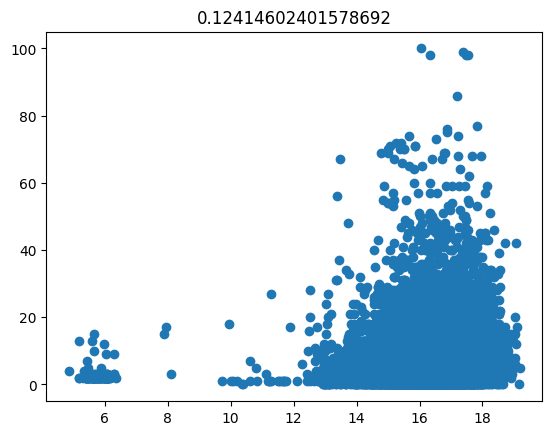

<IPython.core.display.Javascript object>

In [207]:
xs = []
ys = []
for word, synsets in words_in_vocab_synsets.items():
    word_int = word_to_int[word]
    num_synsets = len(synsets)
    wasser_norm = wasser_norms[word_int]
    xs.append(wasser_norm)
    ys.append(num_synsets)

plt.title(pearsonr(xs, ys)[0])
plt.scatter(xs, ys)
plt.show()